#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

#### 目的:檢測與醫療費用相關之變量，找出在醫療費用上具高風險的人

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('insurance.csv')

In [10]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
# 2. 進行 One-Hot Encoding
# 我們針對 sex, smoker, region 三個類別型變數進行轉換
# drop_first=True 是一個統計學技巧，可以避免「虛擬變數陷阱」(多重共線性)
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

print(df_encoded.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


In [15]:
# 計算與 charges 的相關性
correlations = df_encoded.corr()['charges'].sort_values(ascending=False)
print(correlations)

charges             1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64


In [16]:
# 找出費用在全體前 25% 的高消費群體
high_risk_threshold = df['charges'].quantile(0.75)
high_risk_group = df[df['charges'] > high_risk_threshold]

# 分析這群人的特徵
print(f"高風險群體的平均 BMI: {high_risk_group['bmi'].mean():.2f}")
print(f"高風險群體中抽菸者的比例: {high_risk_group['smoker'].value_counts(normalize=True)['yes']:.2%}")

高風險群體的平均 BMI: 31.31
高風險群體中抽菸者的比例: 76.12%


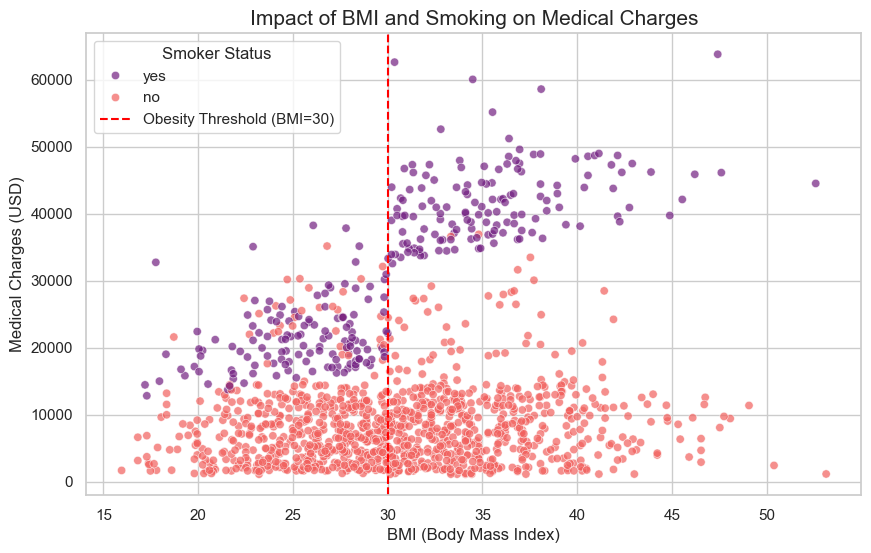

In [20]:



# 2. 設定繪圖風格

sns.set_theme(style="whitegrid")

# 3. 建立散點圖
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=df, 
    x='bmi', 
    y='charges', 
    hue='smoker',      # 根據吸菸狀態區分顏色
    palette='magma',   # 設定配色方案
    alpha=0.7          # 設定點的透明度，方便觀察重疊處
)

# 4. 加入一條關鍵的 BMI 臨界線 (BMI = 30 是肥胖標準)
plt.axvline(x=30, color='red', linestyle='--', label='Obesity Threshold (BMI=30)')

# 5. 優化圖表標籤
plt.title('Impact of BMI and Smoking on Medical Charges', fontsize=15)
plt.xlabel('BMI (Body Mass Index)', fontsize=12)
plt.ylabel('Medical Charges (USD)', fontsize=12)
plt.legend(title='Smoker Status')

plt.show()